# Cost Cutting In Human Resource Management Through Employee Churn Prediction

> An approach to mitigate employee churn using [IBM HR Anlaytics Employee Attrition & PErformance dataset](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset)

- toc: true
- badges: true
- comments: true
- categories: [hr-analytics, churn analysis, classification, recall, ibm-dataset, kaggle]
- image: images/Employee-Attrition.png

#### Import Packages

In [1]:
import math
import time
import copy
import warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import missingno as msno
import statsmodels.formula.api as smf

from pandasql import sqldf
from datetime import datetime
from plotnine import *
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, scale
from sklearn_pandas import DataFrameMapper, gen_features, cross_validation
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML

# settings:
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('display.max_colwidth', -1)  
pd.options.display.max_columns = 100 
pd.options.display.max_rows = 1000 
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus']=False
plt.style.use('ggplot')   # fivethirtyeight
psd = lambda q: sqldf(q, gloabls())
py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

D:\NUS MSBA COURSE\DBA5106 - Foundations in Business Analytics\venv_5106\venv_5106\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


#### Data Overview

In [2]:
d = pd.read_csv('../data/employee_attrition_ibm_data.csv', index_col='EmployeeNumber')
d_orig = d.copy()
display(d.shape, d.head(2))

(1470, 34)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7


#### Null check

In [3]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

In [4]:
d.describe(include='all')   

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.0,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,Y,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,NaN,961,NaN,NaN,606,NaN,NaN,882,NaN,NaN,NaN,326,NaN,673,NaN,NaN,NaN,1470,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,802.485714,NaN,9.192517,2.912925,NaN,1.0,2.721769,NaN,65.891156,2.729932,2.063946,NaN,2.728571,NaN,6502.931293,14313.103401,2.693197,NaN,NaN,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,403.509100,NaN,8.106864,1.024165,NaN,0.0,1.093082,NaN,20.329428,0.711561,1.106940,NaN,1.102846,NaN,4707.956783,7117.786044,2.498009,NaN,NaN,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2094.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,465.000000,NaN,2.000000,2.000000,NaN,1.0,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2911.000000,8047.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,802.000000,NaN,7.000000,3.000000,NaN,1.0,3.000000,NaN,66.000000,3.000000,2.000000,NaN,3.000000,NaN,4919.000000,14235.500000,2.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,1157.000000,NaN,14.000000,4.000000,NaN,1.0,4.000000,NaN,83.750000,3.000000,3.000000,NaN,4.000000,NaN,8379.000000,20461.500000,4.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


#### Target variable : Attrition Label Count

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


No     1233
Yes    237 
Name: Attrition, dtype: int64


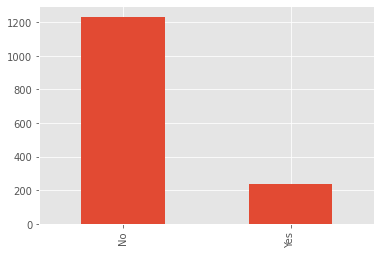

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


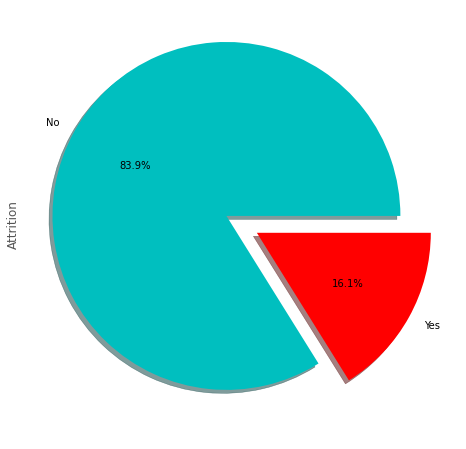

In [5]:
d.Attrition.value_counts().plot(kind='bar')
plt.figure(figsize=(20,8))
d['Attrition'].value_counts().plot(kind='pie',explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=['c','r'])
print(d['Attrition'].value_counts())

### Summary:

*   Dataset Structure: 1470 observations (rows), 35 features (variables)
*   Missing Data: no missing data! this will make it easier to work with the dataset.
*   Data Type: We only have two datatypes in this dataset: categorical and integers
*   Label" Attrition is the label in our dataset and we would like to find out why employees are leaving the organization!
*   Imbalanced dataset: 1237 (84% of cases) employees did not leave the organization while 237 (16% of cases) left the organization making our dataset to be considered imbalanced since more people stay in the organization than they actually leave.

# Exploratory Data Analysis
#### Correlation between Attrtion and Features

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


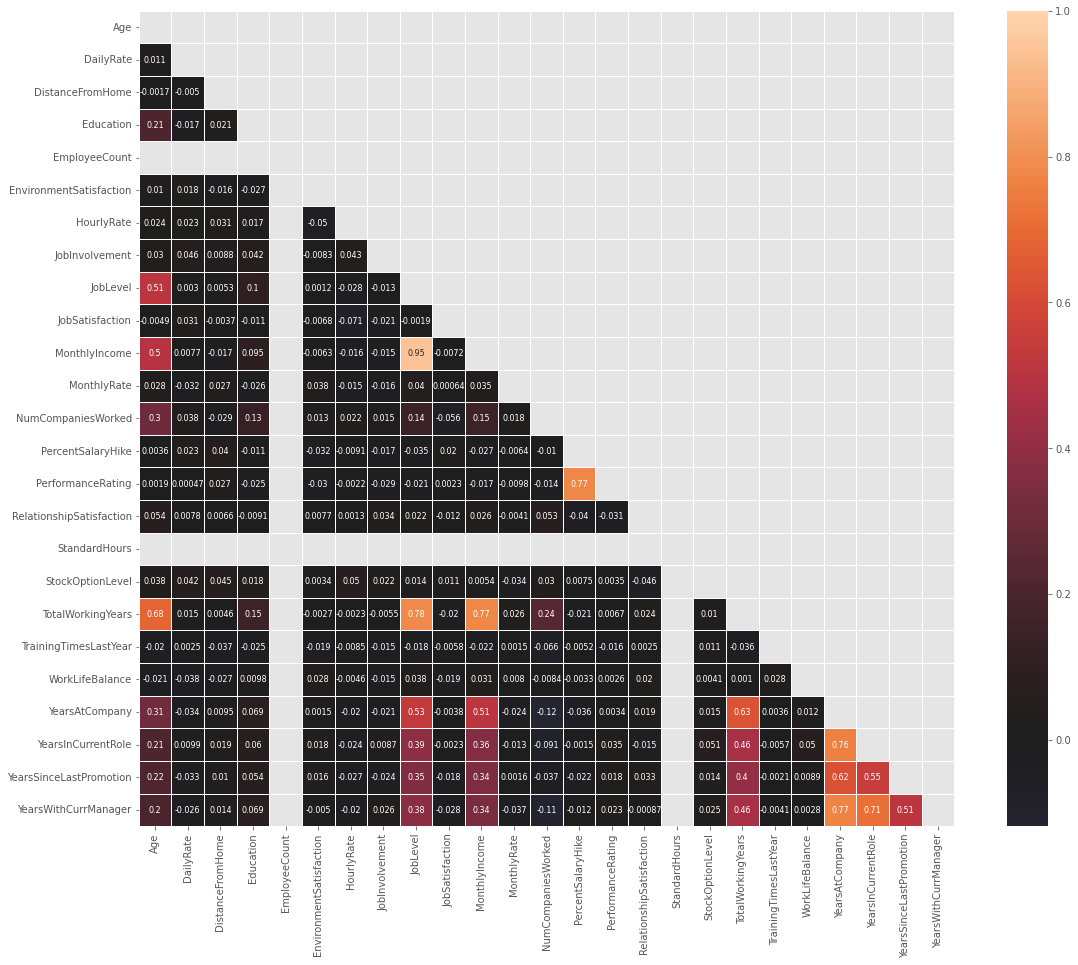

In [6]:
# Subset the dataset into all the numerical values
numeric_hr = d.select_dtypes(include=[np.number])

# Compete the correlation matrix
corr = numeric_hr._get_numeric_data().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(19, 15))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, center=0.0,  annot=True, annot_kws={"size": 8}, # cmap=cmap, 
                      vmax = 1, square=True, linewidths=.5, ax=ax)
plt.show()

**Interpretations:**
- Age: -0.15 ~ With increase in age less likely to attrition ~ which is reasonable
- DailyRate: -0.0056 ~ With increase in DailyRate attrition decreases ~ which is reasonable
- DistanceFromHome: 0.077 ~ With increase in DistanceFromHome attrition is more likely ~ which is reasonable
- Education: -0.031 ~ With higher level of education, attrition becomes less likely ~ which is reasonable
- EnvironmentSatisfaction: -0.103 ~ With higher level of EnvironmentSatisfaction, attrition becomes less likely ~ which is reasonable
- NumCompaniesWorked : 0.043494 ~ With increase in NumCompaniesWorked, more likely to attrition --> reflects tendency to switch more jobs

In [7]:
'''Setting default layouts for all plots'''
# setting a default figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# setting a default style
sns.set_style('darkgrid')

# setting tight layout
plt.figure(tight_layout=True)

# setting a default font sixe for labels
sns.set_context("paper", font_scale=1)

<Figure size 576x432 with 0 Axes>

### **Average Income by Department:**

#### **Q.** What is the average monthly income by department? Are there any significant differences between individuals who quit and didn't quit?

**Income by Departments:**  People with lower salaries had more attrition rate than the one’s being paid well

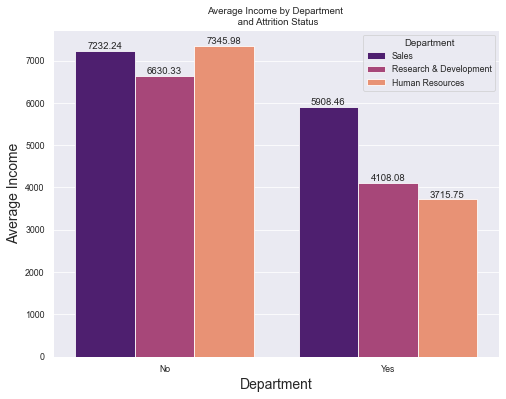

In [8]:
# Plot Option 1
plt.title('Average Income by Department \n and Attrition Status')
plots = sns.barplot(x="Attrition", y="MonthlyIncome", hue="Department", order = ['No','Yes'],data=d, palette = 'magma', ci=None)
for container in plots.containers:
  plt.bar_label(container)
plt.xlabel("Department", size=14)
plt.ylabel("Average Income", size=14)
plt.show()

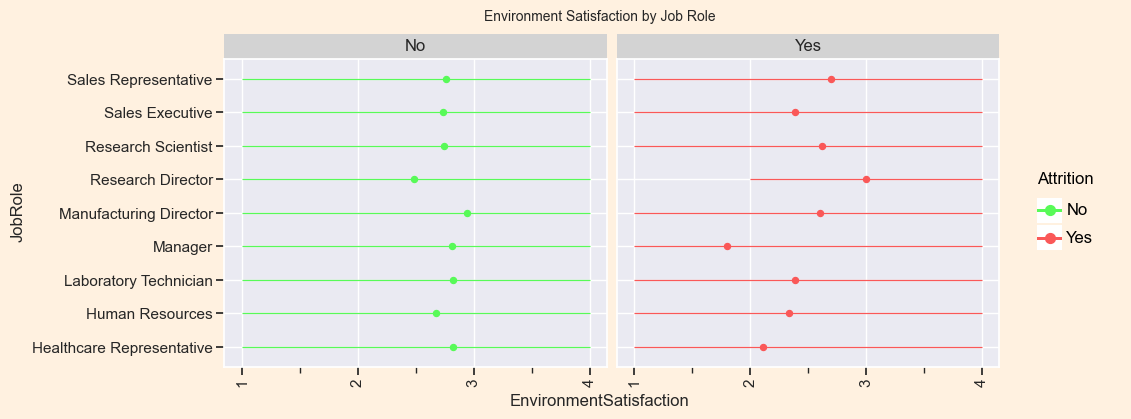

<ggplot: (-9223371922915325936)>

In [9]:
data = d
daily_r = data[['JobRole', 'Attrition', 'EnvironmentSatisfaction']]
gp = ggplot(daily_r, aes(
    x='JobRole', y='EnvironmentSatisfaction', color='Attrition')) + facet_wrap(['Attrition']) + coord_flip() + theme_seaborn() + theme(
        axis_text_x = element_text(angle=90), plot_title=element_text(hjust=0.5, size=10), plot_background=element_rect(fill='#FFF1E0'), figure_size=(10, 4)) + stat_summary(
            fun_y = np.mean, fun_ymin=np.min, fun_ymax=np.max) + scale_color_manual(values=["#58FA58", "#FA5858"]) + labs(title="Environment Satisfaction by Job Role")
gp

Managers and healthcare representatives operate in a less stressful atmosphere than sales representatives, which may be due to the fact that most sales representatives work outside the firm.


### Determining Satisfaction by Income

#### **Q** Are there significant changes in the level of income by Job Satisfaction? Are individuals with a lower satisfaction getting much less income than the ones who are more satisfied?


- **Income by Job Satisfaction**:It seems the lower the job satisfaction the wider the gap by attrition status in the levels of income.

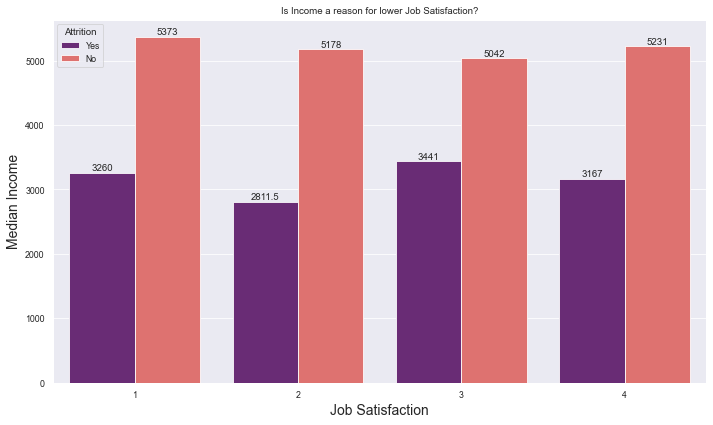

In [10]:
# Plot Option 1: Q2: Is Income a reason for lower Job Satisfaction?
sns.set_style('darkgrid')
plt.figure(figsize = (10, 6), tight_layout=True)
plt.title('Is Income a reason for lower Job Satisfaction?')
plots = sns.barplot(y="MonthlyIncome", x="JobSatisfaction", hue="Attrition", data=data, palette = 'magma',  estimator=np.median, ci=None)
for container in plots.containers:
  plt.bar_label(container)
plt.xlabel("Job Satisfaction", size=14)
plt.ylabel("Median Income", size=14)
plt.show()

#### Q. Were employees more likely to leave their jobs if they spent more time with the same manager?
- Employees who undergo attrititon don't spend more than 2 years with the same manager, irregardless of job satisfaction

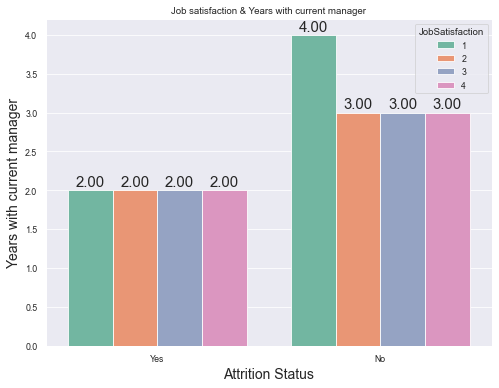

In [11]:
# ManagerExperience + JobSatisfaction
plt.title('Job satisfaction & Years with current manager')
plots = sns.barplot(x="Attrition", y="YearsWithCurrManager", hue="JobSatisfaction", data=data, estimator=np.median, palette = 'Set2', ci=None) 
# for container in plots.containers:
#   plt.bar_label(container)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel("Attrition Status", size=14)
plt.ylabel("Years with current manager", size=14)
plt.show()

#### Q. How does exhaustion contribute to attrition?
- Generally, those who stayed further from home were more likely to undergo attrition. The rate of attrition is especially high among those who worked from home and also worked overtime. This group most likely resigned due to the severe lack of personal time since most of their time is spent working or travelling to work and are probably very exhausted.

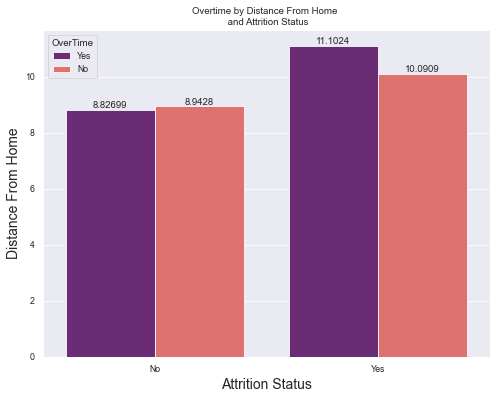

In [12]:
plt.title('Overtime by Distance From Home \n and Attrition Status')
plots = sns.barplot(x="Attrition", y="DistanceFromHome", hue="OverTime", order = ['No','Yes'],data=data, palette = 'magma', ci=None)
for container in plots.containers:
  plt.bar_label(container)
plt.xlabel("Attrition Status", size=14)
plt.ylabel("Distance From Home", size=14)
plt.show()

#### Q.Does relationship satisfaction affect males and females differently with regards to job attrition?

- People who did not undergo attrition seemed to enjoy higher levels of relationship satisfaction. Among those who underwent attrition, females tended to have lower levels of relationship satisfaction.


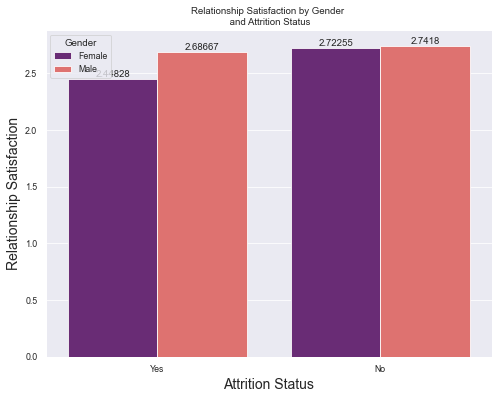

In [13]:
plt.title('Relationship Satisfaction by Gender \n and Attrition Status')
plots = sns.barplot(x="Attrition", y="RelationshipSatisfaction", hue="Gender", order = ['Yes','No'],data=data, palette = 'magma', ci=None)
for container in plots.containers:
  plt.bar_label(container)
plt.xlabel("Attrition Status", size=14)
plt.ylabel("Relationship Satisfaction", size=14)
plt.show()

#### Q. What is the trend of Attrition with respect to the number of years spent in a current role? How is Monthly income distributed among these years?
- The count plot very well reflects the typical tendency of newly recruited professionals, with under 4 years in current roles, to switch jobs frequently if the role is unsatisfactory or for monetary growth until they find stability. 
- Note that there is a hike in attrition among employees with 7,8,9 years of experience which amounts to approximately 21.5% of the total attrition rate in the organisation. 
- The box plot very interestingly highlights that employees with 6 years into their current role are earning more than 13, 14 years into the current role. 
- From these two plots together, we can infer that attrition seems to increase gradually when the monthly income decreases beyond 6 years. T

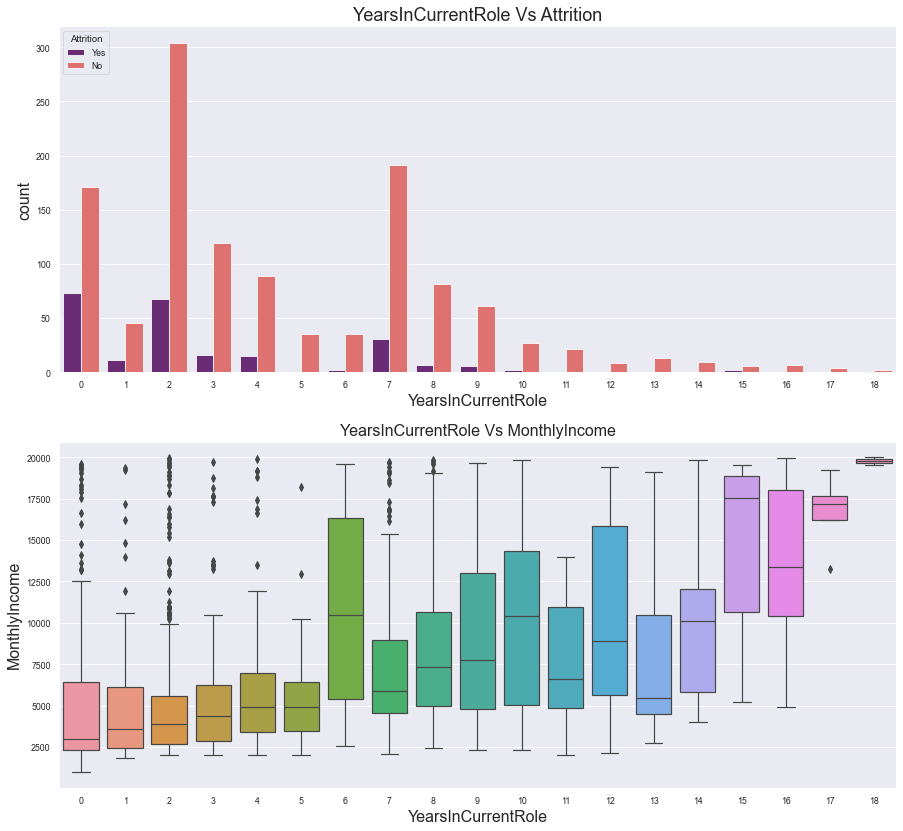

In [14]:
# sns.set_context("paper", font_scale=0.9) 
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":16,"axes.labelsize":16})
plt.figure(figsize=(15,14))
plt.subplot(211)
plt.title('YearsInCurrentRole Vs Attrition',fontsize = 18)
sns.countplot(data['YearsInCurrentRole'],hue=data['Attrition'],palette='magma')

plt.subplot(212)
plt.title('YearsInCurrentRole Vs MonthlyIncome')
sns.boxplot(data['YearsInCurrentRole'],data['MonthlyIncome'])

plt.savefig('YearsIncurrentrole.png',dpi=300)

# Feature Selection and Engineering

### Analysing for different groups of age

<AxesSubplot:title={'center':'Age Wise Binning wrt Attrition'}, xlabel='Age', ylabel='count'>

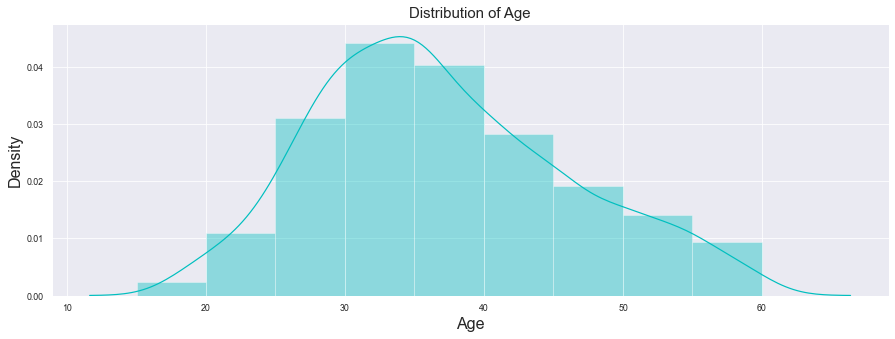

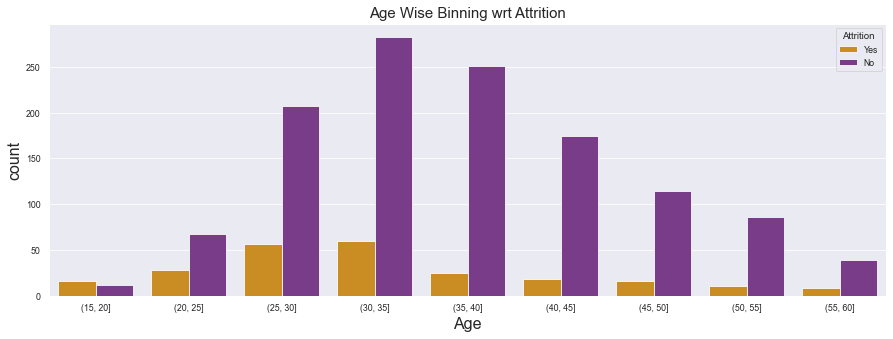

In [15]:
data=d_orig.copy()
agebins=pd.cut(data['Age'],bins=[15,20,25,30,35,40,45,50,55,60]) #Discretisation to understand what age categories to Target
plt.figure(figsize=(15,5))
plt.title('Distribution of Age',size=15)
sns.distplot(data['Age'],bins=[15,20,25,30,35,40,45,50,55,60],color='c')

plt.figure(figsize=(15,5))
plt.title('Age Wise Binning wrt Attrition',size=15)
sns.countplot(agebins, hue='Attrition',data=data,palette='CMRmap_r')

### Data Processing and Feature Engineering

In [16]:
# Reassign target
d.Attrition.replace(to_replace = dict(Yes = 1, No = 0), inplace = True)

# Find & Delete the useless features
li_useless_feat = []
for col in list(d.columns):
    if d[col].nunique() == 1:
        li_useless_feat.append(col)
print('Useless Features:{}'.format(li_useless_feat))
d.drop(columns=li_useless_feat, inplace=True)

# generation-related functions
def age_to_born_yyyy(x):
    return 2015 - x

def cat_generation(x):
    if (x>=1940) & (x<=1959):
        return 'gen_baby_boomer'
    elif (x>=1960) & (x<=1979):
        return 'gen_x'
    elif (x>=1980) & (x<=1994):
        return 'gen_y'
    elif (x>=1995) & (x<=2010):
        return 'gen_z'
    else:
        return 'gen_alpha'        

# Add generation-related columns
d['born_yyyy'] = d.Age.apply(age_to_born_yyyy)
d['generation'] = d.born_yyyy.apply(cat_generation)

display(
    np.round(d.generation.value_counts()/len(d)*100, 2),
    d.shape,
    d.head(2)
)

Useless Features:['EmployeeCount', 'Over18', 'StandardHours']


gen_y              47.69
gen_x              47.21
gen_baby_boomer    3.20 
gen_z              1.90 
Name: generation, dtype: float64

(1470, 33)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,born_yyyy,generation
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,1974,gen_x
2,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,1966,gen_x


### Check for Skewness

Skewness for Hourly Rate is : 0.018577807891132458
Kurtosis for Hourly Rate is : -1.2149560995878737


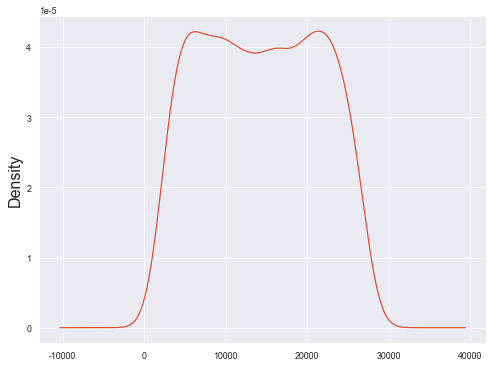

In [17]:
data['MonthlyRate'].plot(kind='kde') 
print('Skewness for Hourly Rate is :' ,data['MonthlyRate'].skew())
print('Kurtosis for Hourly Rate is :' ,data['MonthlyRate'].kurt())

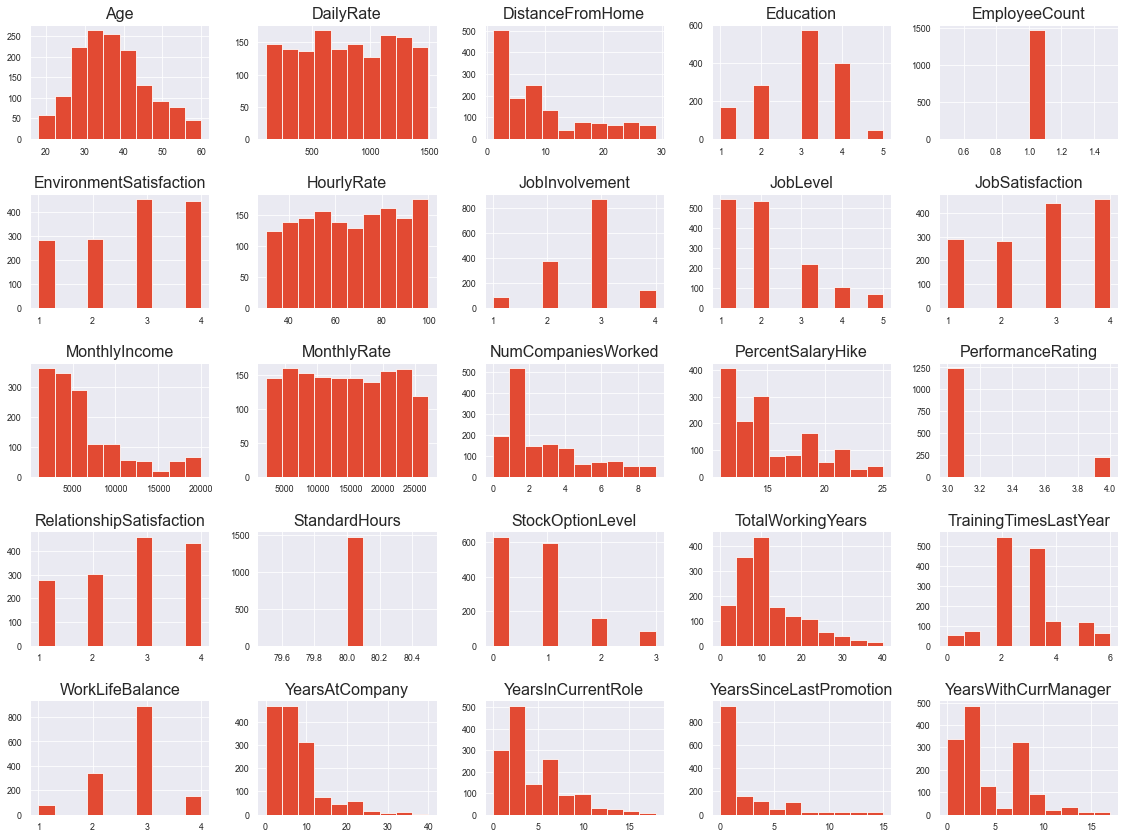

In [18]:
data.hist(figsize=(16,12))
plt.tight_layout()

### Log-Transformed skewed features

In [19]:
log_transform = ['DailyRate', 'Age', 'HourlyRate', 'MonthlyIncome', 'PercentSalaryHike', 'DistanceFromHome', 'MonthlyRate','born_yyyy']
d[log_transform] = np.log(d[log_transform])
d.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,born_yyyy,generation
count,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470
unique,NaN,NaN,3,NaN,3,NaN,NaN,6,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gen_y
freq,NaN,NaN,1043,NaN,961,NaN,NaN,606,NaN,882,NaN,NaN,NaN,326,NaN,673,NaN,NaN,NaN,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,701
mean,3.578034,0.161224,NaN,6.511255,NaN,1.743130,2.912925,NaN,2.721769,NaN,4.135241,2.729932,2.063946,NaN,2.728571,NaN,8.552515,9.402331,2.693197,NaN,2.695025,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,7.589869,NaN
std,0.250205,0.367863,NaN,0.660616,NaN,1.060198,1.024165,NaN,1.093082,NaN,0.334764,0.711561,1.106940,NaN,1.102846,NaN,0.664450,0.633477,2.498009,NaN,0.228224,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,0.004623,NaN
min,2.890372,0.000000,NaN,4.624973,NaN,0.000000,1.000000,NaN,1.000000,NaN,3.401197,1.000000,1.000000,NaN,1.000000,NaN,6.916715,7.646831,0.000000,NaN,2.397895,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.578145,NaN
25%,3.401197,0.000000,NaN,6.142037,NaN,0.693147,2.000000,NaN,2.000000,NaN,3.871201,2.000000,1.000000,NaN,2.000000,NaN,7.976252,8.993055,1.000000,NaN,2.484907,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,7.586804,NaN
50%,3.583519,0.000000,NaN,6.687109,NaN,1.945910,3.000000,NaN,3.000000,NaN,4.189655,3.000000,2.000000,NaN,3.000000,NaN,8.500858,9.563494,2.000000,NaN,2.639057,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,7.590347,NaN
75%,3.761200,0.000000,NaN,7.053586,NaN,2.639057,4.000000,NaN,4.000000,NaN,4.427823,3.000000,3.000000,NaN,4.000000,NaN,9.033484,9.926300,4.000000,NaN,2.890372,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,7.593374,NaN


### Encoding Categorical Variables as per ordinal and nomial meaning


In [20]:
d.select_dtypes(include='object').columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime', 'generation'],
      dtype='object')

In [21]:
ordinal_categorical = ['OverTime']
feature_map = gen_features(columns= ordinal_categorical, classes=[LabelEncoder])
mapping = DataFrameMapper(feature_map)
d[ordinal_categorical] = mapping.fit_transform(d)
print(d.shape)
d.head(3)

(1470, 33)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,born_yyyy,generation
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.713572,1,Travel_Rarely,7.004882,Sales,0.000000,2,Life Sciences,2,Female,4.543295,3,2,Sales Executive,4,Single,8.698347,9.877092,8,1,2.397895,3,1,0,8,0,1,6,4,0,5,7.587817,gen_x
2,3.891820,0,Travel_Frequently,5.631212,Research & Development,2.079442,1,Life Sciences,3,Male,4.110874,2,2,Research Scientist,2,Married,8.542861,10.122904,1,0,3.135494,4,4,1,10,3,3,10,7,1,7,7.583756,gen_x
4,3.610918,1,Travel_Rarely,7.224753,Research & Development,0.693147,2,Other,4,Male,4.521789,2,1,Laboratory Technician,3,Single,7.644919,7.781556,6,1,2.708050,3,2,0,7,3,3,0,0,0,0,7.589842,gen_x


In [22]:
# Encode the nominal_categorical using dummies so that scikit-learn can read them
nominal_categorical = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'generation']
d_dummies = d.copy()
for col in nominal_categorical:
    freqs = d_dummies[col].value_counts()
    k = freqs.index[freqs>5][:-1]                 # does the work of One Hot Encoding
    for cat in k:
        name = col+'_'+cat
        d_dummies[name] = (d_dummies[col] == cat).astype(int)
    del d_dummies[col]
    print(col)
print(d_dummies.shape)
d_dummies.head(2)

BusinessTravel
Department
EducationField
Gender
JobRole
MaritalStatus
generation
(1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,born_yyyy,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Medical,EducationField_Marketing,EducationField_Technical Degree,EducationField_Other,Gender_Male,JobRole_Sales Executive,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Married,MaritalStatus_Single,generation_gen_y,generation_gen_x,generation_gen_baby_boomer
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.713572,1,7.004882,0.000000,2,2,4.543295,3,2,4,8.698347,9.877092,8,1,2.397895,3,1,0,8,0,1,6,4,0,5,7.587817,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
2,3.891820,0,5.631212,2.079442,1,3,4.110874,2,2,2,8.542861,10.122904,1,0,3.135494,4,4,1,10,3,3,10,7,1,7,7.583756,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0


# Classification Models: 

## Logistic Regression, Decision Trees and Random Forest

In [23]:
color = {'LR': 'orange', 'DT': 'green','RFC': 'blue', 'rfc_hp_tuned':'yellow', 'rfc_hp_tuned_balanced':'brown'}

def model_eval(algo, algo_name, X_train , y_train , X_test , y_test):

    algo.fit(X_train , y_train)
    y_pred = algo.predict(X_train)

    y_train_pred = algo.predict(X_train)               # Finding the positives and negatives 
    y_train_prob = algo.predict_proba(X_train)[:,1]    #we are intersted only in the second column

    y_test_pred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:,1]
    
    conf_m = confusion_matrix(y_test , y_test_pred, labels=[0,1])
    FNR = conf_m[1][0] * 100 / (conf_m[1][0] + conf_m[1][1]) 
    
    cv_accuracy=np.mean(cross_val_score(algo, X_test, y_test,cv=5,scoring='accuracy')*100)
    cv_roc_auc=cross_val_score(algo, X_test, y_test,cv=5,scoring='roc_auc')*100
    
    #overall acc of train model
    print('*'*50)
    print(algo_name)
    print("Training Metrics")
    print('Confusion matrix - Train :', '\n',confusion_matrix(y_train , y_train_pred, labels=[0,1]))
    print('Overall Accuracy - Train :',accuracy_score(y_train , y_train_pred))
    print('AUC - Train:', roc_auc_score(y_train , y_train_prob))
    
    print('*'*50)
    print("Testing Metrics")
    print('Confusion matrix - Test :', '\n', conf_m)
    print('Overall Accuracy - Test :',accuracy_score(y_test , y_test_pred))
    print('AUC - Test:', roc_auc_score(y_test , y_test_prob))

    print('*'*50)
    print('\n5-fold Cross Validation Scores')
    print(f'cv_accuracy: {cv_accuracy}\ncv_roc_auc: {np.mean(cv_roc_auc)}\n')
    
    print('Classification Report:\n', classification_report(y_test, y_test_pred))

    fpr , tpr , threshold = roc_curve(y_test , y_test_prob)
    plt.plot(fpr , fpr, 'r-')
    plt.plot(fpr , tpr , color=color[algo_name], label=algo_name)
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc='best')
    
    return y_test_pred, y_test_prob

In [24]:
corr_dummies = d_dummies.corr()
high_corr_cols = corr_dummies[abs(corr_dummies['Attrition']) >= 0.1].index
corr_dummies.loc[high_corr_cols].sort_values(by='Attrition').style.background_gradient(cmap='coolwarm')

y = d_dummies['Attrition']
X = d_dummies[high_corr_cols].drop(['Attrition','Age','TotalWorkingYears'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1470, 16) (1470,)
(1029, 16) (441, 16) (1029,) (441,)


In [25]:
classifiers = {'LR': LogisticRegression(),
               'DT': DecisionTreeClassifier(class_weight='balanced'),
               'RFC': RandomForestClassifier(class_weight='balanced')}

## Classification Model Evaluation

Scores for basic models:

**************************************************
LR
Training Metrics
Confusion matrix - Train : 
 [[849  14]
 [119  47]]
Overall Accuracy - Train : 0.8707482993197279
AUC - Train: 0.8168339638973043
**************************************************
Testing Metrics
Confusion matrix - Test : 
 [[358  12]
 [ 41  30]]
Overall Accuracy - Test : 0.8798185941043084
AUC - Test: 0.826570232204035
**************************************************

5-fold Cross Validation Scores
cv_accuracy: 87.30081716036773
cv_roc_auc: 81.33462033462033

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       370
           1       0.71      0.42      0.53        71

    accuracy                           0.88       441
   macro avg       0.81      0.70      0.73       441
weighted avg       0.87      0.88      0.87       441

**************************************************
DT
Training Metrics
Confusion mat

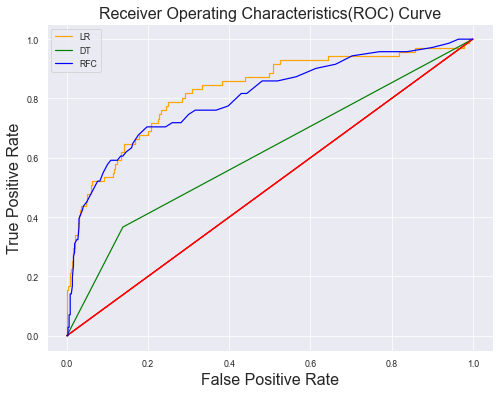

In [26]:
print('Scores for basic models:\n')

for key in classifiers:
    y_test_pred, y_test_prob = model_eval(classifiers[key], key, X_train, y_train, X_test, y_test)

# Data Augmentation
### SMOTE: Synthetic Minority Oversampling Technique
- SMOTE should be applied on the training set. Then, the model should be "evaluated on the stratified but non-transformed test set"

Scores for basic models, trained on augmented balanced data:

(1470, 16) (1470,)
(1726, 16) (441, 16) (1726,) (441,)
(array([0, 1], dtype=int64), array([863, 863], dtype=int64))
**************************************************
LR
Training Metrics
Confusion matrix - Train : 
 [[721 142]
 [137 726]]
Overall Accuracy - Train : 0.8383545770567786
AUC - Train: 0.9083595047591939
**************************************************
Testing Metrics
Confusion matrix - Test : 
 [[294  76]
 [ 27  44]]
Overall Accuracy - Test : 0.7664399092970522
AUC - Test: 0.7647887323943662
**************************************************

5-fold Cross Validation Scores
cv_accuracy: 87.30081716036773
cv_roc_auc: 81.33462033462033

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       370
           1       0.37      0.62      0.46        71

    accuracy                           0.77       441
   macro avg       0.64      0.71      0

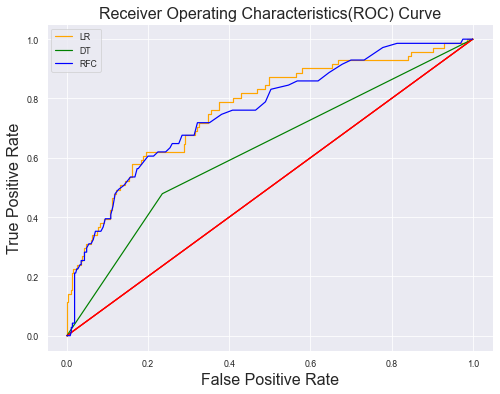

In [27]:
y_aug = copy.deepcopy(y.values)
x_aug = copy.deepcopy(X.values)

def aug_pipeline(clf, clf_name, X_train, y_train, X_test, y_test):
    smt = SMOTE(random_state=0)
    X_train_aug, y_train_aug = smt.fit_resample(X_train, y_train)
    
    print(X.shape, y.shape)
    print(X_train_aug.shape, X_test.shape, y_train_aug.shape, y_test.shape)
    print(np.unique(y_train_aug, return_counts=True))
    
    return model_eval(clf, clf_name, X_train_aug, y_train_aug, X_test, y_test)

print('Scores for basic models, trained on augmented balanced data:\n')

for key in classifiers:
    aug_pipeline(classifiers[key], key, X_train, y_train, X_test, y_test)

# Logistic Regression Model Equations and Feature importance

**************************************************
LR
Training Metrics
Confusion matrix - Train : 
 [[849  14]
 [119  47]]
Overall Accuracy - Train : 0.8707482993197279
AUC - Train: 0.8168339638973043
**************************************************
Testing Metrics
Confusion matrix - Test : 
 [[358  12]
 [ 41  30]]
Overall Accuracy - Test : 0.8798185941043084
AUC - Test: 0.826570232204035
**************************************************

5-fold Cross Validation Scores
cv_accuracy: 87.30081716036773
cv_roc_auc: 81.33462033462033

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       370
           1       0.71      0.42      0.53        71

    accuracy                           0.88       441
   macro avg       0.81      0.70      0.73       441
weighted avg       0.87      0.88      0.87       441



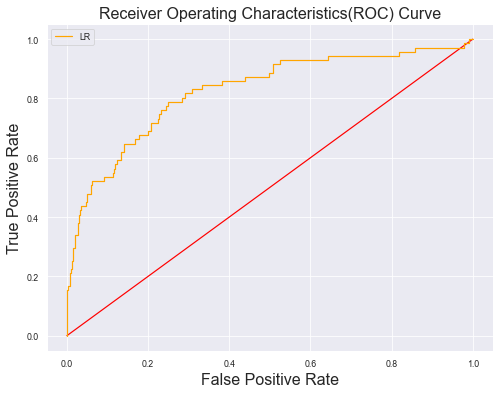

In [28]:
# form F(x) equation for printing in report
lr = LogisticRegression(fit_intercept=True)
y_test_pred, y_test_prob = model_eval(lr, 'LR', X_train , y_train , X_test , y_test)
lr_eqn = f"{round(lr.intercept_[0], 4)} + "
for i in range(len(X_train.columns)):
    lr_eqn = lr_eqn + f"({round(lr.coef_[0][i],3)}*{X_train.columns[i]}) + "

In [29]:
print(lr_eqn)
f_x_test = lr.intercept_[0] + sum([lr.coef_[0][i]*X_test.iloc[:, i] for i in range(len(X_test.columns))])

0.1535 + (-0.403*EnvironmentSatisfaction) + (-0.531*JobInvolvement) + (-0.145*JobLevel) + (-0.415*JobSatisfaction) + (-0.535*MonthlyIncome) + (1.433*OverTime) + (-0.197*StockOptionLevel) + (0.083*YearsAtCompany) + (-0.111*YearsInCurrentRole) + (-0.104*YearsWithCurrManager) + (0.83*born_yyyy) + (0.821*BusinessTravel_Travel_Frequently) + (0.609*JobRole_Sales Representative) + (0.732*MaritalStatus_Single) + (-0.206*generation_gen_y) + (-0.637*generation_gen_x) + 


In [30]:
prob = np.exp(f_x_test) / (1 + np.exp(f_x_test))

In [31]:
results = pd.DataFrame({'Log_odds_f(x)': f_x_test.values,
                        'Probability_p+(x)':prob.values,
                        'Predicted Attrition y_pred': y_test_pred, 
                        'True Attrition y_test': y_test.values},
                       index = f_x_test.index)
results.sort_values(by='True Attrition y_test', ascending=False).head()

,Log_odds_f(x),Probability_p+(x),Predicted Attrition y_pred,True Attrition y_test
EmployeeNumber,,,,
816,0.990499,0.729186,1,1
648,1.057191,0.742153,1,1
1004,0.280909,0.569769,1,1
1458,1.645732,0.838313,1,1
137,0.775118,0.684627,1,1


Text(0, 0.5, 'Probability of Attrition p+(x)')

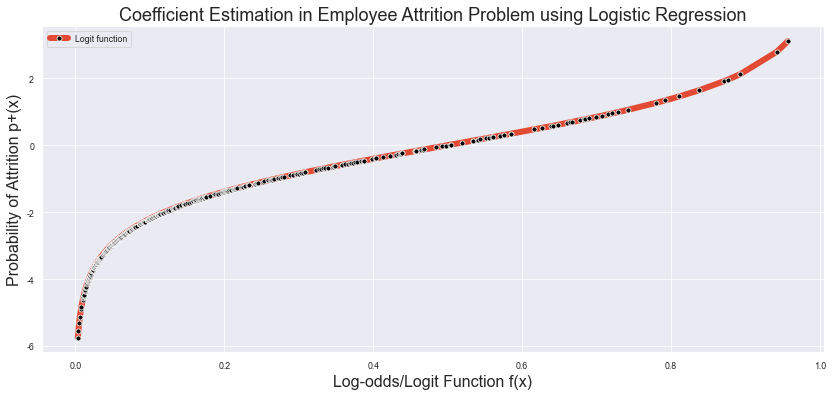

In [32]:
plt.figure(figsize=(14,6))
plt.title('Coefficient Estimation in Employee Attrition Problem using Logistic Regression', fontsize=18)
p = sns.lineplot(data=results, x = 'Probability_p+(x)', y='Log_odds_f(x)',  marker='.', markerfacecolor='black', markersize='10', label='Logit function', linewidth=6)
p.set_xlabel('Log-odds/Logit Function f(x)', fontsize = 16)
p.set_ylabel('Probability of Attrition p+(x)', fontsize = 16)

### Feature Importance for Logistic Regression

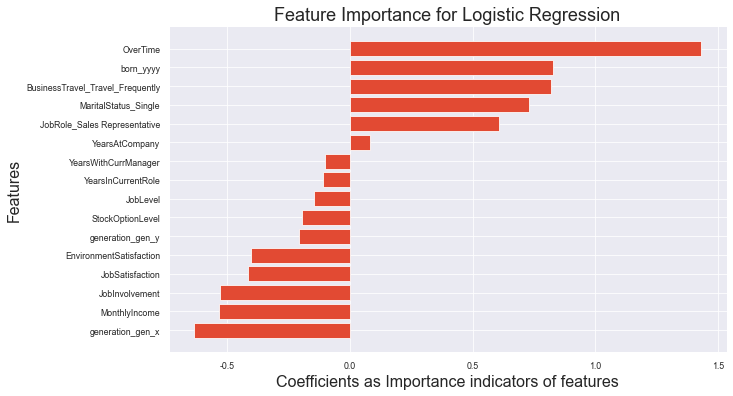

In [33]:
# get importance: in linear models the importance is given by coefficients
importances = lr.coef_[0]
names = X_train.columns
importances, names = zip(*sorted(zip(importances, names)))

# Lets plot this
plt.figure(figsize=(10,6))
plt.barh(range(len(names)), importances, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Coefficients as Importance indicators of features', fontsize = 16)
plt.ylabel('Features',fontsize = 16)
plt.title('Feature Importance for Logistic Regression',fontsize = 18)
plt.show()

### inference:
# We can observe that features that are inversely proportional to attrition such as high job satisfaction, Environment Satisfaction, 

# Random Forest HyperParameter-Tuning and Feature importance

In [ ]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rfc = RandomForestClassifier(random_state=3)
params = { 'n_estimators' : sp_randint(15 , 200) , 
           'max_depth' : sp_randint(2,15) , 
           'min_samples_split' : sp_randint(2,10) ,
           'min_samples_leaf' : sp_randint(1,10) ,
           'criterion' : ['gini' , 'entropy']
    
}

rsearch_rfc = RandomizedSearchCV(rfc , param_distributions= params , n_iter= 50 , cv = 5 , scoring='recall' , random_state= 3 , return_train_score=True , n_jobs=-1)

rsearch_rfc.fit(X,y)

In [ ]:
rsearch_rfc.best_params_   

In [ ]:
rfc= RandomForestClassifier(**rsearch_rfc.best_params_,random_state=3)
y_test_pred, y_test_prob = model_eval(rfc , 'rfc_hp_tuned', X_train , y_train , X_test , y_test)
y_test_pred, y_test_prob =  aug_pipeline(rfc , 'rfc_hp_tuned_balanced', X_train, y_train, X_test, y_test)

In [ ]:
# rfc= RandomForestClassifier(class_weight="balanced")
# y_test_pred, y_test_prob = model_eval(rfc, 'RFC', X_train , y_train , X_test , y_test)
# rfc.get_params(deep=True)
importances = rfc.feature_importances_
names = X_train.columns
importances, names = zip(*sorted(zip(importances, names)))

# Lets plot this
plt.figure(figsize=(12,8))
plt.barh(range(len(names)), importances, align = 'center')
plt.yticks(range(len(names)), names, fontsize = 14)
plt.xlabel('Importance of features', fontsize = 16)
plt.ylabel('Features', fontsize = 16)
plt.title('Feature Importance for Random Forest', fontsize = 18)
plt.show()

# PCR = PCA + Regression/Classification

Principle Component Regression (PCR) is an algorithm for reducing the multi-collinearity of a dataset. The problem we face in multi-variate linear regression (linear regression with a large number of features) is that although it may appear that we do fit the model well, there is normally a high-variance problem on the test set.
PCR is basically using PCA, and then performing Linear Regression on these new PCs.

Bias-Variance Tradeoff
In order to prevent this degree of overfitting, PCR aims to add a slight bias, such that we are now aiming to fit the model with a slightly less training accuracy, but aim to reduce the variance to a large extent. PCR aims to achieve something very similar to what Ridge Regression tries to do. Both of these methods try to reduce overfitting, but differ in their approach

Methodology:

The key idea of how PCR aims to do this, is to use PCA on the dataset before regression.
In PCR instead of regressing the dependent variable on the independent variables directly, the principal components of the independent variables are used.


It is NOT a feature selection method, as a feature selection method would involve selecting a few features as it is, out of all of them. Instead, we are combining features to create new PCs, which are different from the original features.
PCR is particularly useful on datasets facing the problem of multi-collinearity
On datasets with highly correlated features, or even collinear features, PCR is quite useful
PCR reduces the problem of overfitting

**Defining PCA object ~ What's scale for?**
- pca.fit_transform(scale(X)): This tells Python that each of the predictor variables should be scaled to have a mean of 0 and a standard deviation of 1. This ensures that no predictor variable is overly influential in the model if it happens to be measured in different units

In [ ]:
# Defining y and X for basic PCA() Estimation
y = d_dummies.Attrition

# Drop the column with the independent variable Attrtion, non-impacting variable EmployeeNumber and columns for which we have created dummy variables
X = d_dummies.drop(['Attrition'], axis=1)
print(X.shape)
X.head(2)

### Transform Fit PCA + Logistic Regression on entire dataset

In [ ]:
# Check the number of PC's to use during training by classifying the PC's on entire dataset
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

logR = LogisticRegression(random_state=0)
cv_acc_results = []

# Calculate Accuracy with only the intercept (no principal components in Log regression)
score = cross_val_score(logR, np.ones((n,1)), y, cv = kf_10, scoring='accuracy')
cv_acc_results.append(round(score.mean()*100, 2))
print(cv_acc_results)

# Calculate Accuracy using CV for the all principle components, adding one component at the time.
for i in np.arange(1, len(X.columns)):
    score = cross_val_score(logR, X_reduced[:,:i], y, cv=kf_10, scoring='accuracy').mean()
    cv_acc_results.append(round(score.mean()*100, 2))
print(cv_acc_results[30:38])
    # check when results start to exceed 88% what is the number of PCs or n_components
    # We will use this n_components in training and test models

In [ ]:
# Plot results 
plt.figure(figsize=(8,4))
plt.plot(cv_acc_results, '-v')
plt.xlabel('Number of PCs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Cross Validated Accuracy vs Number of PCs', fontsize=18)
plt.xlim(xmin=-1);
# pd.DataFrame(pca.components_.T)

In [ ]:
var_exp = np.round(pca.explained_variance_ratio_, decimals=4)*100
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(7,4))
plt.bar(range(X.shape[1]),var_exp,alpha=0.5,align='center',label='Individual explained variance')
plt.step(range(X.shape[1]),cum_var_exp,where='mid',label='cummulative explained variance')
plt.ylabel("Explained variance ratio", fontsize=16)
plt.xlabel("Number of PCs", fontsize=16)
plt.title('Attrition Explained by k PCs', fontsize=18)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# notice explanatory ratio from 90-95% around 32-35 : we can choose any dimension between this

### Split Dataset

In [ ]:
# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

### Transform fit PCR on Training Dataset and Evlauate Performance

In [ ]:
for i in range(30, 38):
    n_components = i
    pca2 = PCA(n_components=n_components)
    X_reduced_train = pca2.fit_transform(scale(X_train))
    X_reduced_test = pca2.transform(scale(X_test))
    
    logR = LogisticRegression()
    logR.fit(X_reduced_train, y_train)
    
    # PRediction with training data
    y_train_pred = logR.predict(X_reduced_train)
    y_train_prob = logR.predict_proba(X_reduced_train)
    
    # Prediction with test data
    y_pred = logR.predict(X_reduced_test)
    y_test_prob = logR.predict_proba(X_reduced_test)[:,1]
    y_test_pred = y_pred
    algo = logR
    
    conf_m = confusion_matrix(y_test , y_test_pred)
    
    #overall acc of train model
    print('*'*50)
    print("Training Metrics")
    print('Confusion matrix - Train :', '\n',confusion_matrix(y_train , y_train_pred, labels=[0,1]))
    print('Overall Accuracy - Train :',accuracy_score(y_train , y_train_pred))
    
    print('*'*50)
    print("Testing Metrics")
    print('Confusion matrix - Test :', '\n', conf_m)
    print('Overall Accuracy - Test :',accuracy_score(y_test , y_test_pred))
    print('AUC - Test:', roc_auc_score(y_test , y_test_prob))

    print('*'*50)    
    print('Classification Report:\n', classification_report(y_test, y_test_pred))

    fpr , tpr , threshold = roc_curve(y_test , y_test_prob)
    plt.plot(fpr , fpr, 'r-')
    plt.plot(fpr , tpr , label=f'{i} PCs')
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc='best')